# Информация

* *Первый набор данных*

>ID - идентификатор клиента 

>PROD_TYPE - тип карты

>TRANS_DTTM - дата время совершения транзации

>MCC_CODE - код категории продавца

>SUM_TRANS - сумма транзакций

* *Второй набор данных*

>ID - идентификатор клиента 

>MM_IN_BANK - общий стаж в банке, мес.

>MM_W_CARD - стаж использования карты, мес. 

>AGE - число полных лет 

>GENDER - код пола клиента, 

>EDUCATION_LEVEL, 

>MARITAL_STATUS - семейное положение, 

>DEPENDANT_CNT - число иждивенцев, 

>INCOME_MAIN_AMT - уровень дохода, указанный клиентом 

>REG_CODE, закодированный регион регистрации клиента

**В данных есть 50 уникальных MCC кодов**

In [323]:
mcc_codes = pd.read_csv('mcc_codes.csv')
mcc_codes[mcc_codes.MCC.isin(train.MCC_CODE.unique())]

,MCC,Название,Описание
735,4111,Пассажирские перевозки - пригородные и местные...,Услуги местного и пригородного общественного п...
736,4112,Пассажирские железнодорожные перевозки,"Железнодорожные компании, которые в основном п..."
738,4121,Лимузины и такси,"Услуги пассажирских автомобильных перевозок, к..."
739,4131,Автобусные линии,"Услуги пассажирского транспорта, которые работ..."
755,4812,"Телекоммуникационное оборудование, включая про...","Торговые точки, которые продают телекоммуникац..."
757,4814,Телекоммуникационные услуги,"Провайдеры телекоммуникационных услуг, таких к..."
759,4816,"Компьютерные сети, информационные услуги","Провайдеры компьютерных сетей, информационные ..."
763,4900,Жилищно-коммунальные услуги,"Точки, оказывающие услуги по передаче или расп..."
789,5200,Товары для дома,"Торговые точки, ориентированные на широкую пуб..."
790,5211,Лесо- и строительный материал,Продажа в розницу лесо- и строительного матери...


# Импорт модулей

In [191]:
import pandas as pd
import numpy as np
import csv
import json
import requests
from tqdm import tqdm
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.cluster import KMeans
from catboost import CatBoostClassifier, CatBoostRegressor

# Загрузка и обработка данных

In [321]:
mcc_codes = pd.read_csv('mcc_codes.csv')

In [347]:
train1 = pd.read_csv('mts/train_1.csv', sep=';')
train2 = pd.read_csv('mts/train_2.csv', sep=';')

In [9]:
LEN_TRANS_DTTM = train1.TRANS_DTTM.apply(lambda x: len(x))
train1 = train1[LEN_TRANS_DTTM >= 18].reset_index(drop=True)

In [10]:
train1.TRANS_DTTM = pd.to_datetime(train1.TRANS_DTTM, infer_datetime_format=True)

In [11]:
train = pd.merge(train1, train2, on=['ID'], how='left')

In [12]:
def to_float(x):
    try:
        return float(x.replace(',', '.'))
    except:
        return float(x)

train.SUM_TRANS = train.SUM_TRANS.apply(lambda x: to_float(x)).astype(float)

In [13]:
train = train[train.TRANS_DTTM.notnull()].reset_index(drop=True)

In [14]:
train.INCOME_MAIN_AMT = train.INCOME_MAIN_AMT.apply(lambda x: to_float(x))

In [15]:
train = train[train.REG_CODE.notnull()].reset_index(drop=True)
train.REG_CODE = train.REG_CODE.astype(int)

In [16]:
train.loc[train.DEPENDANT_CNT > 7, 'DEPENDANT_CNT'] = 7

In [259]:
train.head(5)

,ID,PROD_TYPE,TRANS_DTTM,MCC_CODE,SUM_TRANS,LOCATION_NAME,MM_IN_BANK,MM_W_CARD,AGE,GENDER,EDUCATION_LEVEL,MARITAL_STATUS,DEPENDANT_CNT,INCOME_MAIN_AMT,REG_CODE
0,500000001271933224,1,2021-10-31 16:04:58,5411,411.45,VERNYJ 1263\5A GORKOGO STR\SERPUKHOV\142203 ...,14,14,24,2,-1,1,0,NaN,32
1,500000001089710588,2,2021-08-20 18:00:39,7311,503.00,AVITO\7 LESNAYA STR\MOSCOW\125196 RUSRUS,16,16,25,2,-1,1,0,NaN,31
2,500000000004725733,1,2021-10-31 07:28:47,5411,119.24,STOLITSA\14 POBEDY PR-T\KOMSOM-NA-AMU\681029 ...,149,5,43,2,-1,3,0,102000.0,79
3,500000000608267511,2,2021-10-31 16:03:14,5411,249.95,VERNYJ 1361\2 MIRA STR\RAMENSKOE\140105 RUSRUS,18,11,57,1,-1,-1,0,NaN,32
4,500000001639102687,1,2021-10-29 13:13:50,5814,290.00,RESTORAN MGRILLCAFE.\LEVAYA STORONA 423-J KM A...,12,0,37,2,5,1,0,45000.0,65


# Разведывательный анализ данных

Часть того, чтобы было в этом разделе перенеслось в разде выше (нашли преобразования, вынесли его наверх), поэтому тут сейчас есть не все, что делалось.

## Просмотр по всем пользователям

In [98]:
train.head(1)

,ID,PROD_TYPE,TRANS_DTTM,MCC_CODE,SUM_TRANS,MM_IN_BANK,MM_W_CARD,AGE,GENDER,EDUCATION_LEVEL,MARITAL_STATUS,DEPENDANT_CNT,INCOME_MAIN_AMT,REG_CODE
0,500000000161890778,1.0,2021-08-10 10:05:33,4121.0,192.0,24.0,9.0,22.0,2.0,5.0,1.0,0.0,50000.0,37.0


In [99]:
train.groupby('REG_CODE').ID.count().sort_values()

REG_CODE
50.0       11
5.0        26
84.0       45
82.0       49
49.0      146
        ...  
65.0    20501
79.0    25982
24.0    26237
32.0    35178
31.0    51985
Name: ID, Length: 85, dtype: int64

In [100]:
train.MCC_CODE.nunique()

50

In [101]:
train.groupby('MCC_CODE').ID.count()

MCC_CODE
4111.0      6675
4112.0       955
4121.0     10653
4131.0     13984
4812.0      1256
4814.0     15517
4816.0      1742
4900.0      2141
5200.0      6130
5211.0      3419
5311.0      6696
5331.0      6542
5399.0      2533
5411.0    129124
5441.0      1589
5451.0       935
5462.0      3799
5499.0     38914
5533.0      3154
5541.0     19641
5641.0       845
5651.0      6145
5661.0      1237
5691.0      4044
5722.0      2270
5732.0      1251
5812.0      9847
5813.0      1162
5814.0     44832
5815.0      1531
5816.0      1785
5818.0      1175
5912.0     17943
5921.0     30864
5941.0      1222
5942.0      1002
5943.0      1265
5945.0      2006
5964.0      1460
5977.0      3158
5992.0      1329
5993.0      4985
5995.0      2139
5999.0      3060
7230.0      1236
7311.0       633
7399.0       824
7994.0       772
7995.0      1800
9402.0       657
Name: ID, dtype: int64

In [102]:
train.groupby('MCC_CODE').SUM_TRANS.describe().sort_values('mean')[['count', '25%', '50%', '75%']]

,count,25%,50%,75%
MCC_CODE,,,,
4131.0,13984.0,28.000000,46.000,69.000000
5462.0,3799.0,60.000000,112.000,201.000000
4111.0,6675.0,52.000000,104.000,260.000000
5451.0,935.0,75.000000,150.000,306.000000
5441.0,1589.0,96.000000,196.000,400.000000
5815.0,1531.0,149.000000,199.000,299.000000
4121.0,10653.0,156.000000,260.000,469.000000
5993.0,4985.0,150.000000,250.000,493.000000
5499.0,38914.0,129.000000,258.000,513.000000


In [103]:
train.groupby('ID').SUM_TRANS.describe().sort_values('mean')[['count', '25%', '50%', '75%']]

,count,25%,50%,75%
ID,,,,
500000000002016357,2.0,18.500,29.00,39.5000
500000000129733450,38.0,13.250,20.00,35.4675
500000000295126601,30.0,29.000,29.00,29.0000
500000000298952598,12.0,27.500,47.00,57.5000
500000000298258657,46.0,21.985,28.25,40.0000
...,...,...,...,...
500000000128676916,15.0,216.500,254.00,650.0000
500000000158664944,23.0,840.000,11900.00,23300.0000
500000000001754652,17.0,2173.000,9537.00,22821.7800


In [104]:
train[train.ID == 500000000000065814].INCOME_MAIN_AMT

12938    24000.0
12939    24000.0
12940    24000.0
12941    24000.0
12942    24000.0
12943    24000.0
12944    24000.0
12945    24000.0
12946    24000.0
12947    24000.0
12948    24000.0
12949    24000.0
12950    24000.0
12951    24000.0
12952    24000.0
12953    24000.0
12954    24000.0
12955    24000.0
12956    24000.0
12957    24000.0
12958    24000.0
12959    24000.0
12960    24000.0
12961    24000.0
12962    24000.0
12963    24000.0
12964    24000.0
12965    24000.0
12966    24000.0
12967    24000.0
Name: INCOME_MAIN_AMT, dtype: float64

In [111]:
train.groupby('ID').agg({'INCOME_MAIN_AMT': 'mean', 'SUM_TRANS': 'sum'}).sample(50)

,INCOME_MAIN_AMT,SUM_TRANS
ID,,
500000000135311404,NaN,145128.790000
500000000130711309,NaN,8635.070000
500000000162904952,102000.0,91510.040000
500000000297188029,30000.0,12749.750000
500000000003410717,15000.0,32490.890000
500000002081595123,70000.0,24339.080000
500000000156360084,NaN,7645.430000
500000000134885991,30000.0,26536.348520
500000000006018873,NaN,68448.220000


In [125]:
temp = train.groupby('REG_CODE').agg({'INCOME_MAIN_AMT': 'mean', 'SUM_TRANS': 'mean'}) \
            .sort_values('INCOME_MAIN_AMT', ascending=False)
temp.INCOME_MAIN_AMT = np.round(temp.INCOME_MAIN_AMT)
temp.SUM_TRANS = np.round(temp.SUM_TRANS)

In [126]:
temp.head(50)

,INCOME_MAIN_AMT,SUM_TRANS
REG_CODE,,
12.0,211802.0,909.0
6.0,198597.0,717.0
15.0,142729.0,960.0
19.0,139720.0,1149.0
31.0,132147.0,1249.0
32.0,110170.0,928.0
53.0,109776.0,1456.0
2.0,99710.0,921.0
57.0,97403.0,1253.0


## Просмотр по одному пользователю

In [134]:
train[train.ID == train.ID.unique()[1]]

,ID,PROD_TYPE,TRANS_DTTM,MCC_CODE,SUM_TRANS,MM_IN_BANK,MM_W_CARD,AGE,GENDER,EDUCATION_LEVEL,MARITAL_STATUS,DEPENDANT_CNT,INCOME_MAIN_AMT,REG_CODE
15,500000000161890811,2.0,2021-07-08 00:37:55,5411.0,100.00,21.0,20.0,31.0,1.0,-1.0,-1.0,0.0,120000.0,8.0
16,500000000161890811,2.0,2021-07-24 11:34:43,5814.0,403.00,21.0,20.0,31.0,1.0,-1.0,-1.0,0.0,120000.0,8.0
17,500000000161890811,2.0,2021-10-20 22:10:39,5411.0,229.80,21.0,20.0,31.0,1.0,-1.0,-1.0,0.0,120000.0,8.0
18,500000000161890811,2.0,2021-10-23 18:07:39,5812.0,1065.00,21.0,20.0,31.0,1.0,-1.0,-1.0,0.0,120000.0,8.0
19,500000000161890811,2.0,2021-10-26 13:11:21,5814.0,545.00,21.0,20.0,31.0,1.0,-1.0,-1.0,0.0,120000.0,8.0
20,500000000161890811,2.0,2021-01-08 21:08:57,5411.0,510.97,21.0,20.0,31.0,1.0,-1.0,-1.0,0.0,120000.0,8.0
21,500000000161890811,2.0,2021-07-27 00:31:14,5411.0,170.00,21.0,20.0,31.0,1.0,-1.0,-1.0,0.0,120000.0,8.0
22,500000000161890811,2.0,2021-10-28 15:16:15,5814.0,380.00,21.0,20.0,31.0,1.0,-1.0,-1.0,0.0,120000.0,8.0
23,500000000161890811,2.0,2021-01-08 13:12:49,5814.0,393.00,21.0,20.0,31.0,1.0,-1.0,-1.0,0.0,120000.0,8.0
24,500000000161890811,2.0,2021-10-31 18:30:12,5411.0,811.93,21.0,20.0,31.0,1.0,-1.0,-1.0,0.0,120000.0,8.0


# Кластеризация

## Подготовка данных

In [261]:
train.head(1)

,ID,PROD_TYPE,TRANS_DTTM,MCC_CODE,SUM_TRANS,LOCATION_NAME,MM_IN_BANK,MM_W_CARD,AGE,GENDER,EDUCATION_LEVEL,MARITAL_STATUS,DEPENDANT_CNT,INCOME_MAIN_AMT,REG_CODE
0,500000001271933224,1,2021-10-31 16:04:58,5411,411.45,VERNYJ 1263\5A GORKOGO STR\SERPUKHOV\142203 ...,14,14,24,2,-1,1,0,NaN,32


In [262]:
FEATURES_FOR_OHE = ['PROD_TYPE', 'MCC_CODE', 'GENDER', 'EDUCATION_LEVEL', 'MARITAL_STATUS', 'REG_CODE']
OTHER_NECESSARY_FEATURES = ['ID', 'SUM_TRANS', 'MM_IN_BANK', 'MM_W_CARD', 'AGE', 'DEPENDANT_CNT']

In [263]:
def ohe_feature(data, feature):
    
    ohe = pd.get_dummies(data[feature])
    ohe.columns = [feature+'_'+str(col) for col in ohe.columns]
    
    return ohe

In [264]:
data_cluster = train[OTHER_NECESSARY_FEATURES].copy()

In [265]:
for feature in tqdm(FEATURES_FOR_OHE):
    data_cluster = pd.concat([data_cluster, ohe_feature(train, feature)], axis=1)

100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.22s/it]


In [266]:
data_cluster.head()

,ID,SUM_TRANS,MM_IN_BANK,MM_W_CARD,AGE,DEPENDANT_CNT,PROD_TYPE_1,PROD_TYPE_2,MCC_CODE_4111,MCC_CODE_4112,...,REG_CODE_77,REG_CODE_78,REG_CODE_79,REG_CODE_80,REG_CODE_81,REG_CODE_82,REG_CODE_83,REG_CODE_84,REG_CODE_85,REG_CODE_86
0,500000001271933224,411.45,14,14,24,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,500000001089710588,503.00,16,16,25,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,500000000004725733,119.24,149,5,43,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,500000000608267511,249.95,18,11,57,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,500000001639102687,290.00,12,0,37,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [267]:
OHE_FEATURES_MAX = []
for feature in ['PROD_TYPE', 'GENDER', 'EDUCATION_LEVEL', 'MARITAL_STATUS']:
    for col in data_cluster.columns:
        if feature in col:
            OHE_FEATURES_MAX.append(col)

OHE_FEATURES_SUM = []
for feature in ['MCC_CODE', 'REG_CODE']:
    for col in data_cluster.columns:
        if feature in col:
            OHE_FEATURES_SUM.append(col)
            
FEATURES_MEAN = ['SUM_TRANS', 'MM_IN_BANK', 'MM_W_CARD', 'AGE', 'DEPENDANT_CNT']

In [268]:
data_cluster_ = data_cluster.groupby('ID')[OHE_FEATURES_SUM].sum()
data_cluster_ = pd.concat([data_cluster_, data_cluster.groupby('ID')[OHE_FEATURES_MAX].max()], axis=1)
data_cluster_ = pd.concat([data_cluster_, data_cluster.groupby('ID')[FEATURES_MEAN].mean()], axis=1)

In [269]:
data_cluster_

,MCC_CODE_4111,MCC_CODE_4112,MCC_CODE_4121,MCC_CODE_4131,MCC_CODE_4812,MCC_CODE_4814,MCC_CODE_4816,MCC_CODE_4900,MCC_CODE_5200,MCC_CODE_5211,...,MARITAL_STATUS_1,MARITAL_STATUS_2,MARITAL_STATUS_3,MARITAL_STATUS_4,MARITAL_STATUS_5,SUM_TRANS,MM_IN_BANK,MM_W_CARD,AGE,DEPENDANT_CNT
ID,,,,,,,,,,,,,,,,,,,,,
500000000000003702,0.0,0.0,2.0,1.0,0.0,22.0,1.0,0.0,0.0,0.0,...,0,0,1,0,0,818.128571,5.0,5.0,35.0,0.0
500000000000004100,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,...,0,0,1,0,0,1403.155534,108.0,0.0,34.0,2.0
500000000000004523,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0,0,1,0,0,1054.159839,0.0,0.0,35.0,0.0
500000000000004529,0.0,0.0,9.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,253.707000,6.0,6.0,38.0,0.0
500000000000004718,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0,0,1,0,0,635.108689,18.0,5.0,39.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500000004694875418,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,580.631538,60.0,5.0,42.0,0.0
500000004694884558,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,9.0,5.0,...,0,0,0,1,0,618.240483,19.0,0.0,37.0,1.0
500000004694909288,2.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,1.0,0.0,...,1,0,0,0,0,1526.564062,33.0,3.0,44.0,2.0


## KMeans

In [104]:
# !pip install yellowbrick

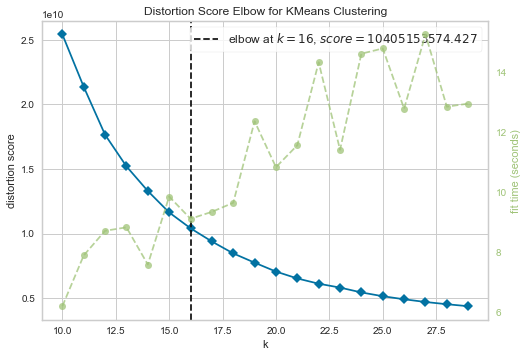

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [67]:
from yellowbrick.cluster import KElbowVisualizer

kmean_model = KMeans()

visualizer = KElbowVisualizer(kmean_model, k=(10, 30), timings=True)
visualizer.fit(data_cluster_) # Fit data to visualizer
visualizer.show() # Finalize and render figure

In [386]:
kmean_model = KMeans(n_clusters=16)

In [387]:
y_pred = kmean_model.fit_predict(data_cluster_)

In [388]:
data_cluster_predicted = data_cluster_.copy()
data_cluster_predicted['cluster'] = y_pred

In [389]:
clusters_count = data_cluster_predicted.groupby('cluster').MCC_CODE_4111.count()

Оставляю только кластеры с вменяемым количеством пользователей

In [390]:
good_clusters = list(clusters_count[clusters_count > 200].index)

In [391]:
good_clusters

[0, 1, 3, 5, 6, 9, 10, 11, 15]

# Модель для предсказаний кластеров

## Обучение кэтбуста на кластерах предсказанных KMeans-ом

In [392]:
data_with_clusters = data_cluster_predicted[data_cluster_predicted.cluster.isin(good_clusters)]

In [393]:
X_train, X_val, y_train, y_val = train_test_split(data_with_clusters.drop(['cluster'], axis=1),
                                                  data_with_clusters['cluster'],
                                                  stratify=data_with_clusters['cluster'],
                                                  test_size=0.15)

In [394]:
model = CatBoostClassifier(verbose=100,
                           eval_metric='Accuracy',
                           early_stopping_rounds=250)

model.fit(X_train, y_train, eval_set=(X_val, y_val))

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Learning rate set to 0.119633
0:	learn: 0.9715873	test: 0.9709774	best: 0.9709774 (0)	total: 221ms	remaining: 3m 40s
100:	learn: 0.9892635	test: 0.9874415	best: 0.9876435 (38)	total: 16.1s	remaining: 2m 23s
200:	learn: 0.9908618	test: 0.9876772	best: 0.9877782 (147)	total: 29.8s	remaining: 1m 58s
300:	learn: 0.9921036	test: 0.9873742	best: 0.9877782 (147)	total: 43.3s	remaining: 1m 40s
Stopped by overfitting detector  (250 iterations wait)

bestTest = 0.9877781893
bestIteration = 147

Shrink model to first 148 iterations.


In [ ]:
model.save_model('models_claster')

> Точность модели = 99%

> Эту модель можно использовать для содания предсказаний на новых данных

## Создаю предсказания для пользователей с тяжело различмым кластером

In [395]:
data_out_clusters = data_cluster_predicted[~data_cluster_predicted.cluster.isin(good_clusters)].copy()

In [396]:
data_out_clusters['cluster'] = model.predict(data_out_clusters.drop(['cluster'], axis=1))

In [397]:
data_out_clusters.groupby('cluster').AGE.count()

cluster
1    340
3     19
Name: AGE, dtype: int64

## Объединение кластеризированных данных

In [398]:
data_clusterized = pd.concat([data_with_clusters, data_out_clusters], axis=0).reset_index()

In [399]:
data_clusterized.head()

,ID,MCC_CODE_4111,MCC_CODE_4112,MCC_CODE_4121,MCC_CODE_4131,MCC_CODE_4812,MCC_CODE_4814,MCC_CODE_4816,MCC_CODE_4900,MCC_CODE_5200,...,MARITAL_STATUS_2,MARITAL_STATUS_3,MARITAL_STATUS_4,MARITAL_STATUS_5,SUM_TRANS,MM_IN_BANK,MM_W_CARD,AGE,DEPENDANT_CNT,cluster
0,500000000000003702,0.0,0.0,2.0,1.0,0.0,22.0,1.0,0.0,0.0,...,0,1,0,0,818.128571,5.0,5.0,35.0,0.0,0
1,500000000000004100,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,...,0,1,0,0,1403.155534,108.0,0.0,34.0,2.0,10
2,500000000000004523,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0,1,0,0,1054.159839,0.0,0.0,35.0,0.0,0
3,500000000000004529,0.0,0.0,9.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,253.707000,6.0,6.0,38.0,0.0,6
4,500000000000004718,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,635.108689,18.0,5.0,39.0,0.0,9


In [400]:
data_clusterized.to_csv('data_clusterized.csv', index=False)

# Описание кластеров

In [271]:
data_clusterized = pd.read_csv('data_clusterized.csv')

In [272]:
MCC_CODE_COLUMNS = [x for x in data_clusterized.columns if 'MCC_CODE' in x]

In [273]:
cluster_mcc_description = data_clusterized.groupby('cluster')[MCC_CODE_COLUMNS].sum()
cluster_mcc_description['SUM_TRANS'] = data_clusterized.groupby('cluster')['SUM_TRANS'].mean()
cluster_mcc_description = cluster_mcc_description.T

In [276]:
for c in cluster_mcc_description.columns:
    
    sum_trans = cluster_mcc_description[c].iloc[-1]
    sum_actions = cluster_mcc_description[c].iloc[:-1].sum()
    temp = cluster_mcc_description[c].iloc[:-1].sort_values(ascending=False)
    temp = temp.iloc[:10].reset_index().rename(columns={'index': 'MCC_CODE'})
    temp.MCC_CODE = temp.MCC_CODE.apply(lambda x: x[9:]).astype(int)
    
    descs = []
    for mcc_code in temp.MCC_CODE:
        descs.append(mcc_codes[mcc_codes.MCC == mcc_code]['Название'].iloc[0])
    
    print('Популярность категорий для {} кластера:'.format(c))
    for mcc_code, val, mcc_decs in zip(temp['MCC_CODE'], temp[c], descs):
        print(mcc_code, '–––', str(round(100 * val / sum_actions, 2))+'%', '–––', mcc_decs)
    print('Средняя сумма транзакций:', round(sum_trans, 2))
    print()

Популярность категорий для 0 кластера:
5411 ––– 31.3% ––– Бакалейные магазины, супермаркеты
5814 ––– 10.4% ––– Фастфуд
5499 ––– 8.83% ––– Различные продовольственные магазины - нигде более не классифицированные
5921 ––– 6.08% ––– Магазины с продажей спиртных напитков навынос
5541 ––– 5.6% ––– Заправочные станции (с вспомогательными услугами или без)
5912 ––– 4.62% ––– Аптеки
4814 ––– 3.26% ––– Телекоммуникационные услуги
5812 ––– 2.51% ––– Места общественного питания, рестораны
4121 ––– 2.23% ––– Лимузины и такси
5651 ––– 1.75% ––– Одежда для всей семьи
Средняя сумма транзакций: 967.58

Популярность категорий для 1 кластера:
5411 ––– 15.62% ––– Бакалейные магазины, супермаркеты
7995 ––– 13.07% ––– Азартные игры
5814 ––– 9.36% ––– Фастфуд
4814 ––– 5.89% ––– Телекоммуникационные услуги
5541 ––– 5.88% ––– Заправочные станции (с вспомогательными услугами или без)
5499 ––– 4.47% ––– Различные продовольственные магазины - нигде более не классифицированные
5812 ––– 3.99% ––– Места общественно

# Предсказание следующей покупки

## Подготовка данных

In [432]:
data_match = train.drop(['LOCATION_NAME'], axis=1)
data_match = data_match.sort_values(['ID', 'TRANS_DTTM']).reset_index(drop=True)

In [433]:
print(data_match.TRANS_DTTM.min())
print(data_match.TRANS_DTTM.max())

2021-07-01 00:00:06
2021-10-31 23:59:57


In [434]:
data_match['month'] = data_match.TRANS_DTTM.apply(lambda x: x.month)
data_match['day'] = data_match.TRANS_DTTM.apply(lambda x: x.day)
data_match['hour'] = data_match.TRANS_DTTM.apply(lambda x: x.hour)

In [435]:
data_match = data_match.drop(['TRANS_DTTM', 'PROD_TYPE'], axis=1)

In [436]:
for col in ['MCC_CODE', 'SUM_TRANS']:
    for i in range(1, 6):
        data_match['{}_lag_{}'.format(col, i)] = data_match.groupby('ID')[col].shift(i)

In [437]:
data_match = pd.merge(data_match, data_clusterized[['ID', 'cluster']], on='ID', how='left')

In [438]:
cat_features = ['GENDER', 'EDUCATION_LEVEL', 'MARITAL_STATUS', 'REG_CODE', 'month', 'day', 'hour',
                'MCC_CODE_lag_1', 'MCC_CODE_lag_2', 'MCC_CODE_lag_3', 'MCC_CODE_lag_4', 'MCC_CODE_lag_5',
                'cluster']

In [439]:
data_match[cat_features] = data_match[cat_features].fillna(-1).astype(int)

In [440]:
data_match.to_feather('data_match.ftr')

## Модель для MCC_CODE

In [293]:
cat_features = ['GENDER', 'EDUCATION_LEVEL', 'MARITAL_STATUS', 'REG_CODE', 'month', 'day', 'hour',
                'MCC_CODE_lag_1', 'MCC_CODE_lag_2', 'MCC_CODE_lag_3', 'MCC_CODE_lag_4', 'MCC_CODE_lag_5',
                'cluster']

_, data_match_ = train_test_split(data_match, test_size=(1000000/data_match.shape[0]), 
                                  stratify=data_match['MCC_CODE'])

X_train, X_val, y_train, y_val = train_test_split(data_match_.drop(['ID', 'MCC_CODE', 'SUM_TRANS'], axis=1),
                                                  data_match_['MCC_CODE'],
                                                  stratify=data_match_['MCC_CODE'],
                                                  test_size=0.15)

In [294]:
model = CatBoostClassifier(verbose=100,
                           task_type='GPU',
                           cat_features=cat_features,
                           early_stopping_rounds=250)

model.fit(X_train, y_train, eval_set=(X_val, y_val))

In [295]:
model.save_model(data_dir+'match_model')

(8500, 23)

## Модель для SUM_TRANS

In [ ]:
cat_features = ['GENDER', 'EDUCATION_LEVEL', 'MARITAL_STATUS', 'REG_CODE', 'month', 'day', 'hour',
                'MCC_CODE_lag_1', 'MCC_CODE_lag_2', 'MCC_CODE_lag_3', 'MCC_CODE_lag_4', 'MCC_CODE_lag_5',
                'cluster']

_, data_match_ = train_test_split(data_match, test_size=(5000000/data_match.shape[0]), 
                                  stratify=data_match['MCC_CODE'])

X_train, X_val, y_train, y_val = train_test_split(data_match_.drop(['ID', 'MCC_CODE', 'SUM_TRANS'], axis=1),
                                                  data_match_['SUM_TRANS'],
                                                  test_size=0.15)

In [ ]:
model = CatBoostRegressor(verbose=100,
                          task_type='GPU',
                          cat_features=cat_features,
                          early_stopping_rounds=250)

model.fit(X_train, y_train, eval_set=(X_val, y_val))

In [ ]:
model.save_model(data_dir+'match_model_TRANS_SUM')

## Важность признаков

In [ ]:
fip = pd.DataFrame()
fip['col'] = data_trigger.drop(['ID', 'MCC_CODE', 'SUM_TRANS'], axis=1).columns
fip['mcc_val'] = model_mcc.get_feature_importance()
fip['trans_val'] = model_transum.get_feature_importance()

In [ ]:
fip.sort_values('mcc_val', ascending=False)

,col,mcc_val,trans_val
11,hour,14.677564,6.406607
8,REG_CODE,9.108863,2.323686
13,MCC_CODE_lag_2,7.488035,1.827720
12,MCC_CODE_lag_1,7.224687,1.885676
2,AGE,6.724099,2.728651
14,MCC_CODE_lag_3,6.648913,1.504734
15,MCC_CODE_lag_4,6.321896,1.682638
16,MCC_CODE_lag_5,5.769456,1.653299
17,SUM_TRANS_lag_1,3.941607,6.757370
18,SUM_TRANS_lag_2,3.758678,4.986459


In [ ]:
fip.sort_values('trans_val', ascending=False)

,col,mcc_val,trans_val
22,cluster,3.357679,49.742319
17,SUM_TRANS_lag_1,3.941607,6.757370
11,hour,14.677564,6.406607
18,SUM_TRANS_lag_2,3.758678,4.986459
0,MM_IN_BANK,3.019058,3.446367
10,day,1.669316,3.345693
2,AGE,6.724099,2.728651
8,REG_CODE,9.108863,2.323686
19,SUM_TRANS_lag_3,2.854295,2.260676
20,SUM_TRANS_lag_4,2.701965,1.929928


# Работа с геокодером

In [ ]:
# https://search-maps.yandex.ru/v1/
#  ? apikey=<ключ>
#  & text=<поисковый запрос>
#  & lang=<язык ответа>
#  & [type=<типы объектов>] # biz
#  & [ll=<центр области поиска>]
#  & [spn=<размеры области поиска>]
#  & [bbox=<координаты области поиска>]
#  & [rspn=<не искать за пределами области поиска>]
#  & [results=<количество результатов в ответе>]
#  & [skip=<количество пропускаемых результатов>]
#  & [callback=<имя функции>]

In [16]:
API_KEY = ''

In [27]:
# url = 'https://search-maps.yandex.ru/v1/?text={}&ll={}&spn=0.005,0.005&lang=ru_RU&apikey={}'.format(mcc_text, coordinates, API_KEY) 

# response = requests.request("GET", url)

In [48]:
json.loads(response.text)['features'][0]

{'type': 'Feature',
 'geometry': {'type': 'Point', 'coordinates': [30.316281, 59.969232]},
 'properties': {'name': 'Азиаты',
  'description': 'просп. Медиков, 3, Санкт-Петербург, Россия',
  'boundedBy': [[30.3121755, 59.96717394], [30.3203865, 59.97128994]],
  'CompanyMetaData': {'id': '70183167427',
   'name': 'Азиаты',
   'address': 'Россия, Санкт-Петербург, проспект Медиков, 3',
   'Categories': [{'class': 'fast food', 'name': 'Быстрое питание'}],
   'Hours': {'text': 'пн-сб 12:00–19:00',
    'Availabilities': [{'Intervals': [{'from': '12:00:00', 'to': '19:00:00'}],
      'Monday': True,
      'Tuesday': True,
      'Wednesday': True,
      'Thursday': True,
      'Friday': True,
      'Saturday': True}]}}}}

# Получение рекомендаций

In [18]:
data_trigger = pd.read_feather('data_match.ftr')

In [174]:
model_mcc = CatBoostClassifier()
model_mcc.load_model('match_model')

model_transum = CatBoostRegressor()
model_transum.load_model('match_model_TRANS_SUM')

In [102]:
mcc_classes = model_mcc.classes_

## Топ рекомендованных категорий

In [181]:
def top_max_probs(x, k=5):
    return list(x.sort_values(ascending=False).head(k).index)

In [182]:
def get_mcc_predictions(data, k=5):
    mcc_probs = model_mcc.predict_proba(data)
    pred_data = pd.DataFrame()
    pred_data[mcc_classes] = mcc_probs
    t = pred_data.apply(lambda x: top_max_probs(x, k), axis=1)
    return t

In [235]:
def get_trans_sum_prediction(data):
    return model_transum.predict(data)

In [101]:
temp_trigger = data_trigger.sample(100000).copy()

In [278]:
t = get_mcc_predictions(temp_trigger.drop(['ID', 'MCC_CODE', 'SUM_TRANS'], axis=1), k=1)

In [283]:
metrs = []

for j in tqdm(range(20)):
    
    t = get_mcc_predictions(temp_trigger.drop(['ID', 'MCC_CODE', 'SUM_TRANS'], axis=1), k=j)
    
    k = 0
    for i in range(len(t)):
        if temp_trigger.MCC_CODE.iloc[i] in t.iloc[i]:
            k += 1
            
    metrs.append(100 * k / 100000)

100%|███████████████████████████████████████████| 20/20 [02:44<00:00,  8.22s/it]


In [284]:
import matplotlib.pyplot as plt

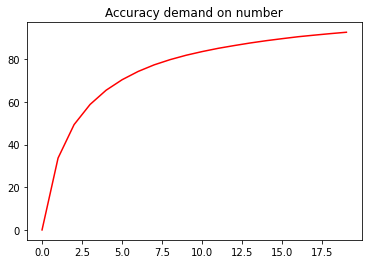

In [287]:
plt.plot(metrs, color='red')
plt.title('Accuracy demand on number')
plt.savefig('acc.png')

## Сборка данных для новых кейсов (не из датасета)

In [150]:
users_triggered = data_trigger.drop_duplicates(['ID']).reset_index(drop=True).copy()
users_triggered = users_triggered.drop(['MCC_CODE', 'SUM_TRANS', 'month', 'day', 'hour'], axis=1)

In [177]:
feature_names = model_mcc.feature_names_

In [178]:
def add_features(idx, month, day, hour):
    tadd = pd.DataFrame()
    tadd['ID'] = [idx]
    tadd['month'] = month
    tadd['day'] = day
    tadd['hour'] = hour
    return pd.merge(tadd, users_triggered, on='ID', how='left')[feature_names]

In [188]:
t = get_mcc_predictions(add_features(500000004694957908, 11, 1, 10))

In [189]:
t

0    [5411, 4814, 5541, 5814, 5499]
dtype: object

# Реальное тестирование

In [328]:
API_KEY = ''

In [332]:
def get_recommendation(USER_ID, hour, day, month, lat, lon):

    pred = get_mcc_predictions(add_features(USER_ID, month, day, hour))[0]
    pred_mcc = [mcc_codes[mcc_codes.MCC == x]['Название'].iloc[0] for x in pred]
    pred_trans_sum = round(get_trans_sum_prediction(add_features(USER_ID, month, day, hour))[0], 2)
    
    if USER_ID in [500000000050666088, 500000000006899340]:
        mcc_get = pred_mcc[-1]
    else:
        mcc_get = pred_mcc[0]
    
    url = 'https://search-maps.yandex.ru/v1/?text={}&ll={},{}&spn=0.005,0.005&lang=ru_RU&apikey={}' \
          .format(mcc_get, lat, lon, API_KEY) 
    
    response = requests.request("GET", url)
    rec = json.loads(response.text)['features'][0]
    
    mean_trans_sum = round(train[train.MCC_CODE == pred[-1]].SUM_TRANS.mean(), 2)
    
    print(rec['properties']['name'])
    print(rec['properties']['CompanyMetaData']['address'])
    print('Прогнозируемая сумма покупки: ', pred_trans_sum)
    print('Средняя сумма по категории:', mean_trans_sum)
    
    if pred_trans_sum > mean_trans_sum:
        print('Пользователь находится в зеленой зоне, рекомендация не требуется')
        
    elif pred_trans_sum < mean_trans_sum:
        print('Пользователь находится в красной зоне, рекомендация требуется\n')
        print('Посетите {} на сумму больше {} рублей и получите повышенный кэшбэк'.format(rec['properties']['name'],
                                                                                          round(mean_trans_sum)))

In [340]:
hour = 12
day = 14
month = 11

lat = 30.316299
lon = 59.969835

In [344]:
USER_IDS = [500000000050666088, 500000000006899340, 
            500000000053419272, 500000000007469011]

In [346]:
print('\n')

for uid in USER_IDS:
    
    print('Рекомендация для пользователя с ID', uid)
    print('Время: {}:00 {}.{}.2021'.format(hour, day, month))
    print('Координаты {}, {}\n'.format(lat, lon))
    get_recommendation(uid, hour, day, month, lat, lon)
    print('\n')



Рекомендация для пользователя с ID 500000000050666088
Время: 12:00 14.11.2021
Координаты 30.316299, 59.969835

Футура
Россия, Санкт-Петербург, набережная реки Карповки, 5, корп. 36
Прогнозируемая сумма покупки:  1373.04
Средняя сумма по категории: 903.7
Пользователь находится в зеленой зоне, рекомендация не требуется


Рекомендация для пользователя с ID 500000000006899340
Время: 12:00 14.11.2021
Координаты 30.316299, 59.969835

Футура
Россия, Санкт-Петербург, набережная реки Карповки, 5, корп. 36
Прогнозируемая сумма покупки:  757.49
Средняя сумма по категории: 903.7
Пользователь находится в красной зоне, рекомендация требуется

Посетите Футура на сумму больше 900 рублей и получите повышенный кэшбэк


Рекомендация для пользователя с ID 500000000053419272
Время: 12:00 14.11.2021
Координаты 30.316299, 59.969835

Лэнд
Россия, Санкт-Петербург, улица Льва Толстого, 9
Прогнозируемая сумма покупки:  794.1
Средняя сумма по категории: 464.8
Пользователь находится в зеленой зоне, рекомендация 